In [1]:

#Libraries

import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Arima

In [2]:
#ARIMA

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import numpy as np

In [3]:
df=pd.read_csv('archive/DL001.csv',header=0,parse_dates=['From Date'],index_col=['From Date'])
df.head()
df_ts=df.drop(labels='To Date',axis=1)
df_ts
series_co= df_ts['CO (mg/m3)'].to_frame()
series_co=series_co['2018-08':]
co_w=series_co.resample('W',label='right',closed='right').mean().dropna()

co_m=series_co.resample('ME',label='right',closed='right').mean().dropna()
co_d= series_co.resample('3 d',label='right',closed='right').mean().dropna()


# Seasonal Decompose

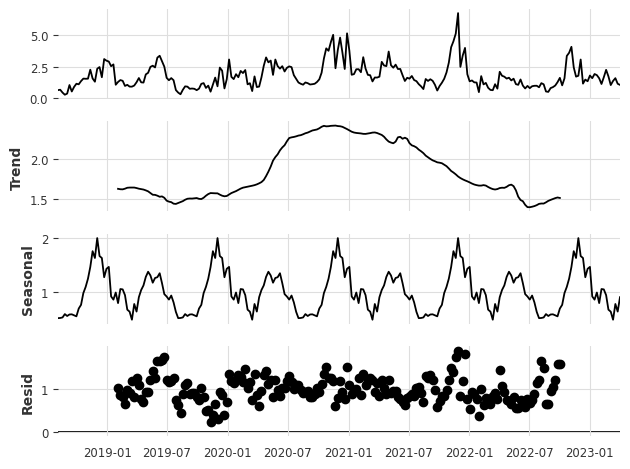

In [4]:
sd=seasonal_decompose(co_w,model='multiplicative')
sd.plot()
plt.show()


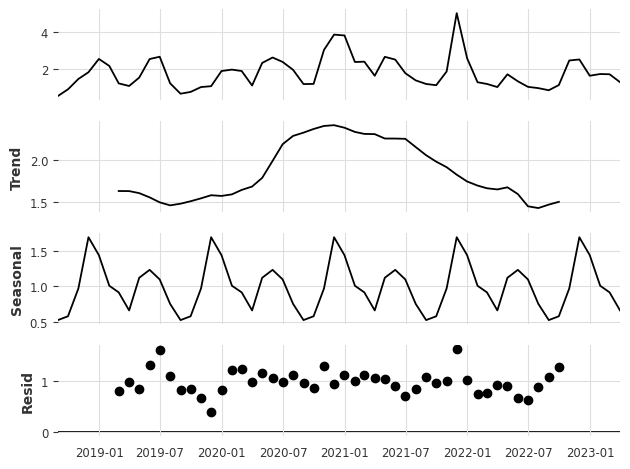

In [5]:
sd_m=seasonal_decompose(co_m,model='multiplicative')
sd_m.plot()
plt.show()

# Log to delete multivicative effect

## Weekly

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

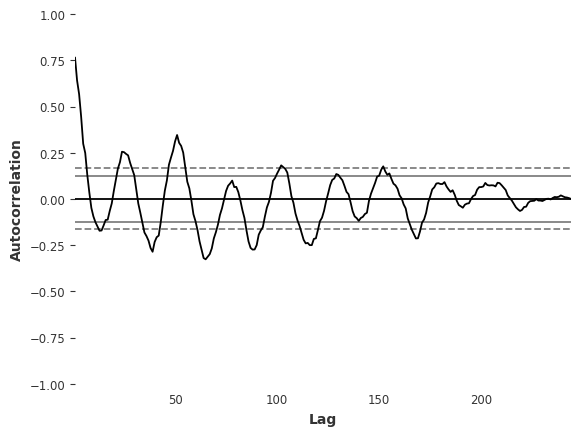

In [6]:
co_w_log=np.log(co_w)
pd.plotting.autocorrelation_plot(co_w_log)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

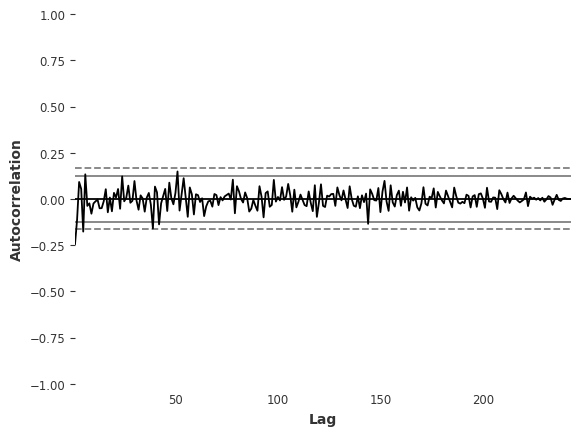

In [7]:

co_w_log_diff=co_w_log.diff().dropna()
pd.plotting.autocorrelation_plot(co_w_log_diff)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

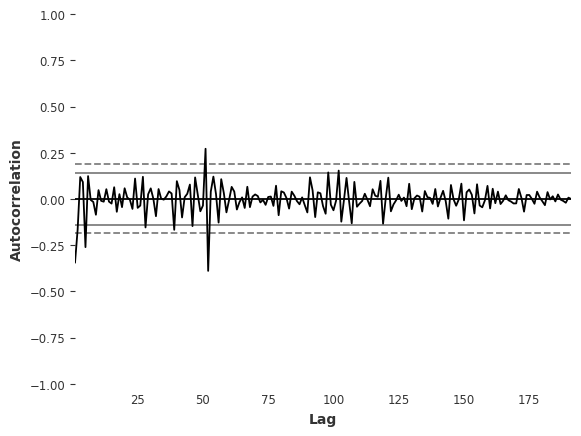

In [8]:

co_w_log_diff_season=co_w_log_diff.diff(periods=52).dropna()
pd.plotting.autocorrelation_plot(co_w_log_diff_season)

## MOnthly

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

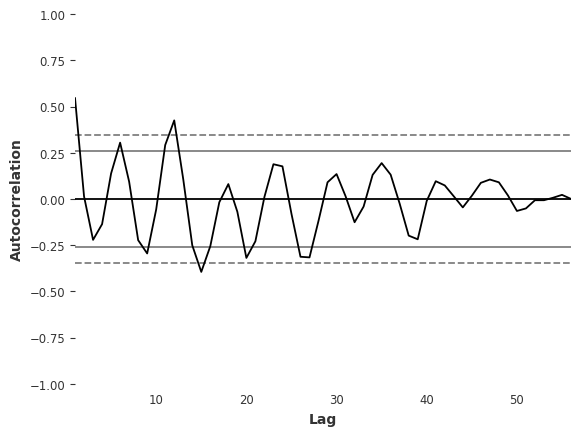

In [9]:
co_m_log=np.log(co_m)
pd.plotting.autocorrelation_plot(co_m_log)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

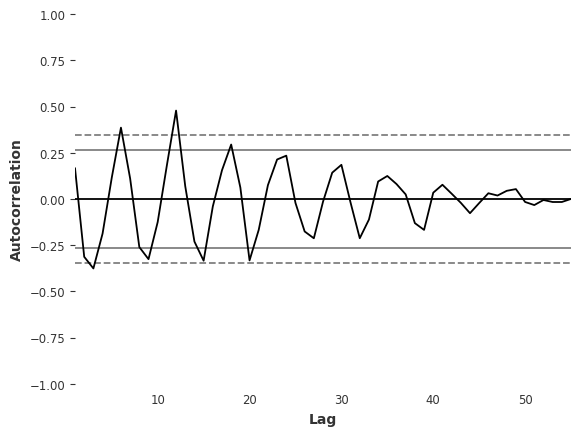

In [10]:
co_m_log_diff=co_m_log.diff().dropna()
pd.plotting.autocorrelation_plot(co_m_log_diff)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

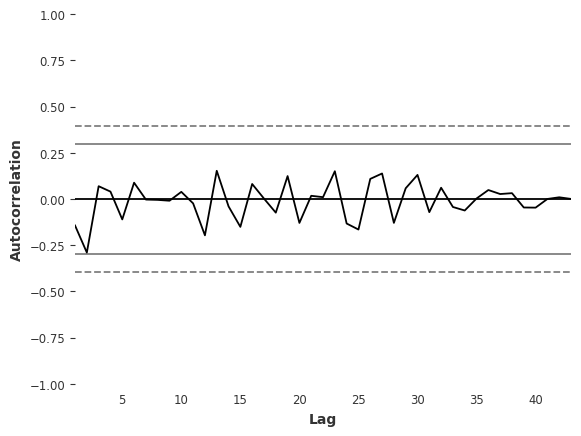

In [11]:
co_m_log_diff_season=co_m_log_diff.diff(periods=12).dropna()
pd.plotting.autocorrelation_plot(co_m_log_diff_season)

# Check stationarity 

In [12]:
result=adfuller(co_m_log_diff_season)
print(f'P-Value is {result[1]}')
if result[1]< 0.05:
    print('La serie est stationnaire')
else:
    print('The serie is not stationnary')

P-Value is 4.630177878874528e-09
La serie est stationnaire


In [13]:
result=adfuller(co_w_log_diff_season)
print(f'P-Value is {result[1]}')
if result[1]< 0.05:
    print('La serie est stationnaire')
else:
    print('The serie is not stationnary')

P-Value is 7.852705866983177e-09
La serie est stationnaire


# Sarima

 SARIMA(𝑝,𝑑,𝑞)(𝑃,𝐷,𝑄)𝑘
 - k = 52 o 12 if weekly or monthly
 - d = 1
 - D = 1

 for now we have Sarima(p,1,q)(P,1,Q)12,52

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [15]:
co_m_log_diff_season.shape

(43, 1)

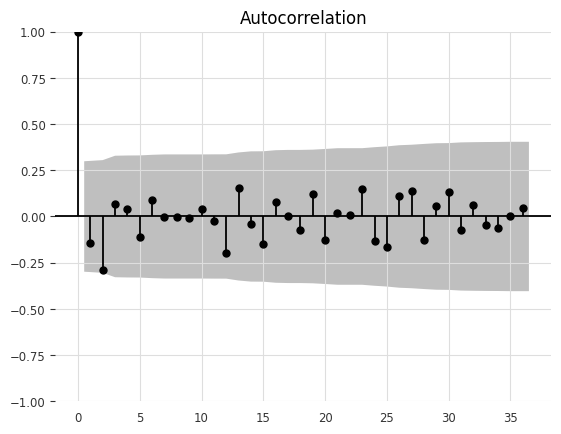

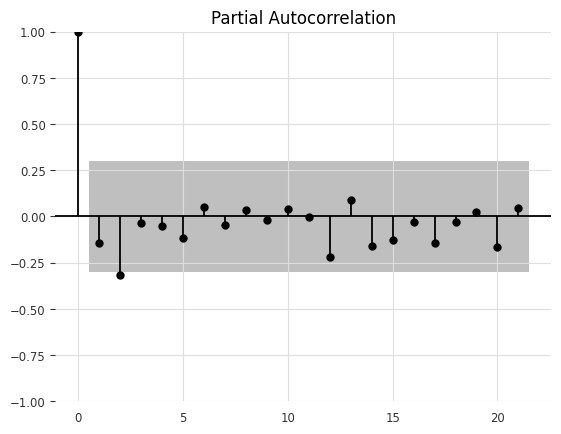

In [16]:
plot_acf(co_m_log_diff_season,lags=36)
plot_pacf(co_m_log_diff_season,lags=21)
plt.show()

acf and pacf tend to 0 so ARMA(1,1) for normal data


[]

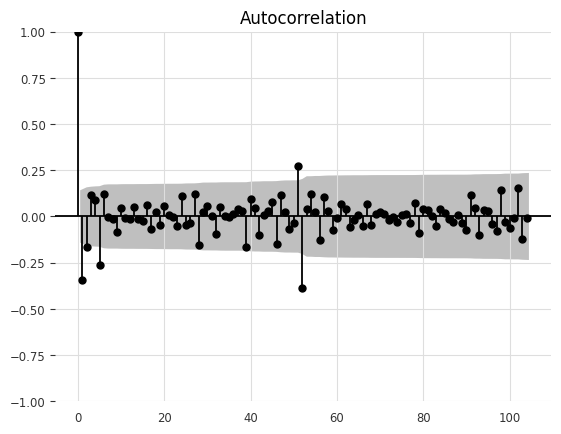

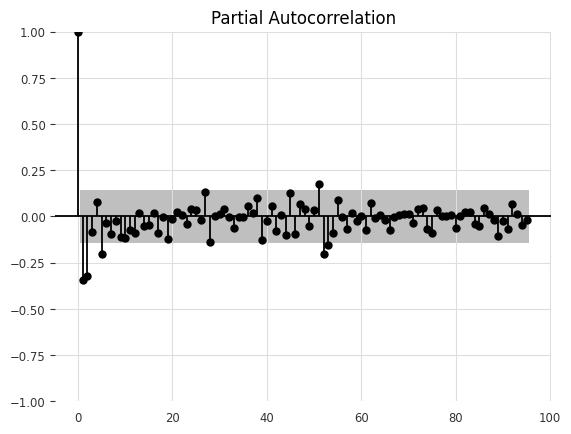

In [17]:
plot_acf(co_w_log_diff_season,lags=104)
plot_pacf(co_w_log_diff_season,lags=95)
plt.plot()

In [18]:
model_w =sm.tsa.SARIMAX(co_w_log,order=(1,1,1),seasonal_order=(0,1,0,52))

model_w_fitted=model_w.fit()
print(model_w_fitted.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52276D-01    |proj g|=  2.37109D-02

At iterate    5    f=  5.47397D-01    |proj g|=  4.23194D-02


 This problem is unconstrained.



At iterate   10    f=  5.45579D-01    |proj g|=  4.69241D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   4.692D-06   5.456D-01
  F =  0.54557897029702285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                          CO (mg/m3)   No. Observations:                  244
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -133.121
Date:                             Sun, 09 Jun 2024   AIC                            2

Prob Q and Prb JB are above 0.05

In [19]:

model_m =sm.tsa.SARIMAX(co_m_log,order=(0,1,1),seasonal_order=(0,1,0,12))

model_m_fitted=model_m.fit()
print(model_m_fitted.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21181D-01    |proj g|=  1.04963D-01

At iterate    5    f=  3.18658D-01    |proj g|=  5.20021D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     10      1     0     0   5.200D-06   3.187D-01
  F =  0.31865752246357454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                          

 This problem is unconstrained.


Prob Q and JB are above 0.05 so we have a white noise and normal distribution for residus

# Predictions

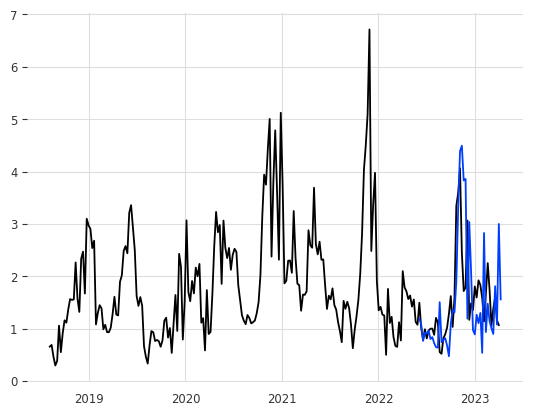

In [20]:
pred_w= np.exp(model_w_fitted.predict(200,244))
co_pred=pd.concat([co_w,pred_w])
plt.plot(co_pred)

In [31]:
type(co_pred)

pandas.core.frame.DataFrame

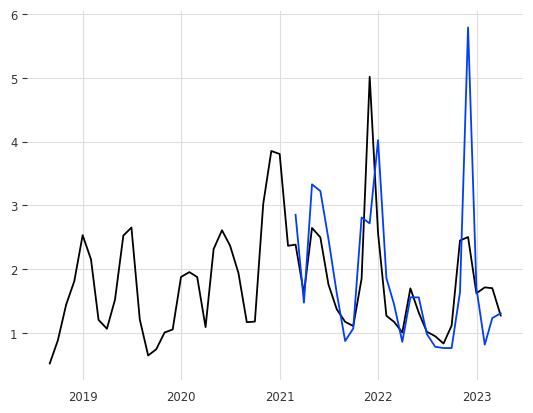

In [21]:
pred_m= np.exp(model_m_fitted.predict(30,55))
co_pred_m=pd.concat([co_m,pred_m])
plt.plot(co_pred_m)

# Forecasting

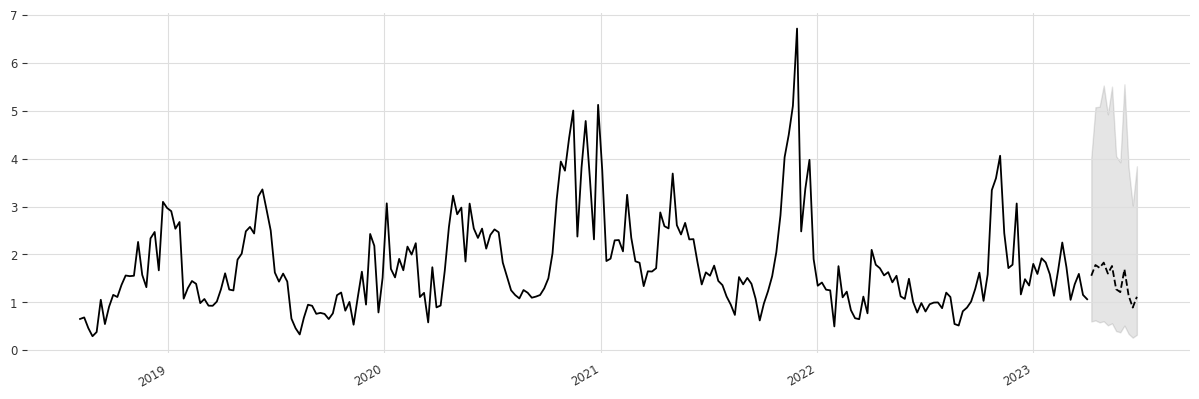

In [22]:
prediction_w = model_w_fitted.get_forecast(steps =12).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(co_w)
#prediction = np.exp(prediction) #Passage à l'exponentielle
prediction_w= np.exp(prediction_w)
prediction_w['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne

ax.fill_between(prediction_w.index, prediction_w['mean_ci_lower'], prediction_w['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

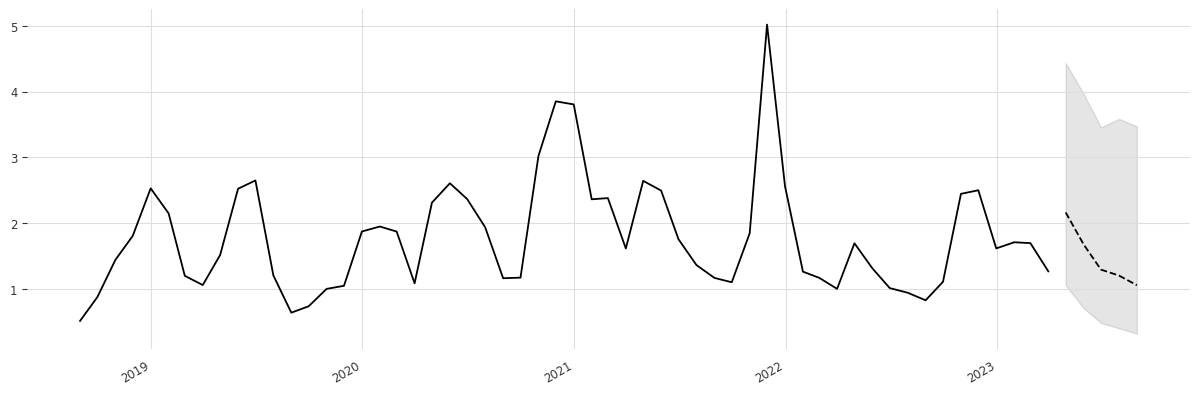

In [23]:
prediction_m = model_m_fitted.get_forecast(steps =5).summary_frame()  #Prédiction avec intervalle de confiance

fig2, ax = plt.subplots(figsize = (15,5))

plt.plot(co_m)
#prediction = np.exp(prediction) #Passage à l'exponentielle
prediction_m= np.exp(prediction_m)
prediction_m['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne

ax.fill_between(prediction_m.index, prediction_m['mean_ci_lower'], prediction_m['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

# Evaluation

## Weekly

In [24]:
mape_w=mean_absolute_percentage_error(co_w[200:244],pred_w[:-1])
mape_w

0.4506370534105795

In [25]:
mse_w=mean_squared_error(co_w[200:244],pred_w[:-1])
mse_w

0.8420165190866413

In [26]:
w_merge=pd.merge(co_w[200:244],pred_w,left_index=True,right_index=True)
w_merge

,CO (mg/m3),predicted_mean
2022-06-05,1.492857,1.188969
2022-06-12,1.011317,1.075570
2022-06-19,0.787483,0.763636
2022-06-26,0.986048,0.917994
2022-07-03,0.810000,0.903796
2022-07-10,0.961071,0.961353
2022-07-17,0.995774,0.799103
2022-07-24,0.999286,0.835331
2022-07-31,0.879157,0.722161
2022-08-07,1.203292,0.644144


In [27]:
pred_w[:-1].index==co_w[200:244].index


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Monthly

In [28]:
mape_m=mean_absolute_percentage_error(co_m[30:55],pred_m[:-1])
mape_m

0.29982747269985865

In [29]:
pred_m[:-1].index==co_m[30:55].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [30]:
m_merge=pd.merge(co_m[30:55],pred_m,left_index=True,right_index=True)
m_merge

,CO (mg/m3),predicted_mean
From Date,,
2021-02-28,2.381781,2.850744
2021-03-31,1.616658,1.470297
2021-04-30,2.643808,3.327662
2021-05-31,2.495607,3.222533
2021-06-30,1.756815,2.470157
2021-07-31,1.365372,1.615482
2021-08-31,1.170450,0.869338
2021-09-30,1.103859,1.065869
2021-10-31,1.848176,2.807486
